# Advanced ML: Домашнее задание 1 - Староверова Таисия

In [163]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

## 1. Загрузка данных

In [122]:
raw_data = pd.read_csv("owid-covid-data.csv")
df = raw_data.loc[(raw_data["location"] == "Russia") & (raw_data["date"] >= "2020-03-03")]
df.loc[df['new_cases'] == 0, 'new_cases'] = 1
df = df.set_axis([i for i in range(df.shape[0])])
df.head()

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


iso_code continent location        date  total_cases  new_cases  \
0      RUS    Europe   Russia  2020-03-03          3.0        1.0   
1      RUS    Europe   Russia  2020-03-04          3.0        1.0   
2      RUS    Europe   Russia  2020-03-05          4.0        1.0   
3      RUS    Europe   Russia  2020-03-06         13.0        9.0   
4      RUS    Europe   Russia  2020-03-07         13.0        1.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0               0.143           NaN         NaN                  NaN  ...   
1               0.143           NaN         NaN                  NaN  ...   
2               0.286           NaN         NaN                  NaN  ...   
3               1.571           NaN         NaN                  NaN  ...   
4               1.571           NaN         NaN                  NaN  ...   

   female_smokers  male_smokers  handwashing_facilities  \
0            23.4          58.3                     NaN   
1            23.4          58.3                     NaN   
2            23.4          58.3                     NaN   
3            23.4          58.3                     NaN   
4            23.4          58.3                     NaN   

   hospital_beds_per_thousand  life_expectancy  human_development_index  \
0                        8.05            72.58                    0.824   
1                        8.05            72.58                    0.824   
2                        8.05            72.58                    0.824   
3                        8.05            72.58                    0.824   
4                        8.05            72.58                    0.824   

   excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
0                                   NaN                          NaN   
1                                   NaN                          NaN   
2                                   NaN                          NaN   
3                                   NaN                          NaN   
4                                   NaN                          NaN   

   excess_mortality  excess_mortality_cumulative_per_million  
0               NaN                                      NaN  
1               NaN                                      NaN  
2               NaN                                      NaN  
3               NaN                                      NaN  
4               NaN                                      NaN  

[5 rows x 67 columns]

<AxesSubplot:xlabel='date'>

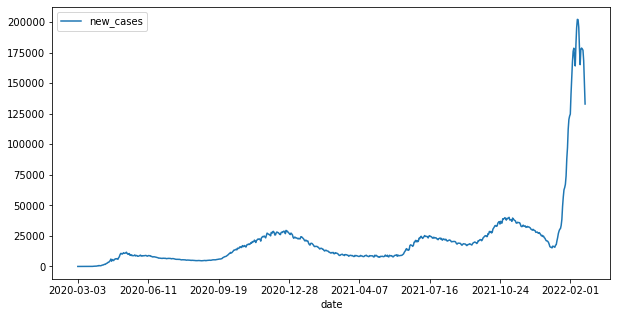

In [123]:
df.plot(x="date", y=["new_cases"], figsize=(10, 5))

<AxesSubplot:xlabel='date'>

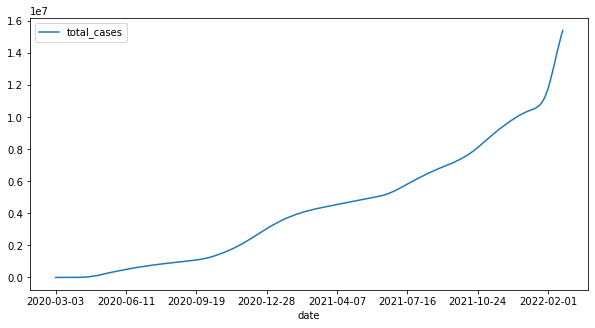

In [124]:
df.plot(x="date", y=["total_cases"], figsize=(10, 5))

## 2а. Линейная регрессия с экспоненциальным ростом числа заболевших

In [125]:
selected_data = df[["date", "new_cases"]].copy()
selected_data['num_days'] = np.arange(1, selected_data.shape[0] + 1)
log_data = pd.DataFrame()
log_data['new_cases_log'] = np.log(selected_data['new_cases'])
log_data['num_days_log'] = np.log(selected_data['num_days'])
log_data

new_cases_log  num_days_log
0         0.000000      0.000000
1         0.000000      0.693147
2         0.000000      1.098612
3         2.197225      1.386294
4         0.000000      1.609438
..             ...           ...
717      12.089629      6.576470
718      12.083476      6.577861
719      12.034091      6.579251
720      11.917497      6.580639
721      11.797443      6.582025

[722 rows x 2 columns]

In [247]:
x_train = selected_data.iloc[:50]["num_days"].values
x_train_reshaped = np.reshape(x_train, (-1, 1))
y_train = log_data.iloc[:50]["new_cases_log"].values
y_train_non_log = selected_data.iloc[:50]["new_cases"].values

x_test = selected_data.iloc[50:]["num_days"].values
x_test_reshaped = np.reshape(x_test, (-1, 1))
y_test = log_data.iloc[50:]["new_cases_log"].values
y_test_non_log = selected_data.iloc[50:]["new_cases"].values

In [333]:
reg = LinearRegression()
reg.fit(x_train_reshaped, y_train)
k = reg.coef_[0]
b = reg.intercept_
k, b

(0.18596309168510522, 0.13472442721454136)

In [249]:
def predict_target(x):
    return np.exp(k * x + b)

In [250]:
first_may_idx = df[(df["date"] == "2020-05-01")].index[0]
first_may_target = df.loc[[first_may_idx], "new_cases"].values[0]
first_june_idx = df[(df["date"] == "2020-06-01")].index[0]
first_june_target = df.loc[[first_june_idx], "new_cases"].values[0]
first_september_idx = df[(df["date"] == "2020-09-01")].index[0]
first_september_target = df.loc[[first_september_idx], "new_cases"].values[0]

In [251]:
y_pred = [predict_target(x) for x in x_test]
print("1 мая предсказано", y_pred[first_may_idx - 50], "вместо", first_may_target)
print("1 июня предсказано", y_pred[first_june_idx - 50], "вместо", first_june_target)
print("1 сентября предсказано", y_pred[first_september_idx - 50], "вместо", first_september_target)

1 мая предсказано 80218.53912662613 вместо 7933.0
1 июня предсказано 25581136.197873984 вместо 8485.0
1 сентября предсказано 688798716454583.4 вместо 4670.0


## 2b. Нахождение апостериорного распределения параметров модели

In [252]:
y_pred_train = [predict_target(x) for x in x_train]
mu = np.array([0, 0])
sigma = np.std(y_pred_train) * np.array([[1, 0], [0, 1]])

N = 250
X = np.linspace(-4, 4, N)
Y = np.linspace(-4, 4, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

Z = multivariate_normal.pdf(pos, mean=mu, cov=sigma)

In [253]:
def get_likelihood(px, py, sigma=sigma):
    return lambda x : np.exp(-(x[0] + x[1]*px - py) ** 2) / (2 * sigma * np.sqrt(2.*np.pi))

In [254]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, 
                    np.matmul(np.linalg.inv(sigma), np.transpose(mu)) 
                    + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [298]:
for q in range(len(x_train)):
    px, py = x_train[q], y_train[q]
    non_log_y = y_train_non_log[q]
    if q == 0: 
        points = [[px], [py]]
        non_log_points = [[px], [non_log_y]]
    else: 
        points[0].append(px)
        points[1].append(py)
        non_log_points[0].append(px)
        non_log_points[1].append(non_log_y)
    cur_likelihood = get_likelihood(px, py)
    Z = np.array([[ cur_likelihood(pos[i, j]) for j in range(pos.shape[1])] for i in range(pos.shape[0])])
    mu, sigma = bayesian_update(mu, sigma, px, py)
    Z = multivariate_normal.pdf(pos, mean=mu, cov=sigma)

<ipython-input-253-e1348afb8e65>:2: RuntimeWarning: divide by zero encountered in true_divide
  return lambda x : np.exp(-(x[0] + x[1]*px - py) ** 2) / (2 * sigma * np.sqrt(2.*np.pi))
<ipython-input-253-e1348afb8e65>:2: RuntimeWarning: invalid value encountered in true_divide
  return lambda x : np.exp(-(x[0] + x[1]*px - py) ** 2) / (2 * sigma * np.sqrt(2.*np.pi))


In [264]:
def myplot_heatmap(Z):
    plt.axis('equal')
    plt.xlim((0, 1))
    plt.ylim((-1, 1))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)

<ipython-input-264-ce40bd350cef>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)


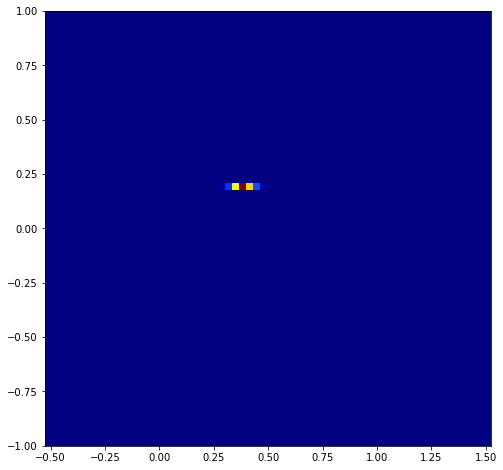

In [265]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((-1, 1))
ax.set_ylim((-1, 1))
myplot_heatmap(Z)

## 2с. Сэмплирование

In [281]:
xs = np.arange(-1, 51, 0.01)

def myplot_sample_lines(mu, sigma, n=20, points=None):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    for w in my_w:
        plt.plot(xs, w[0] + w[1]*xs, 'k-', lw=.4)
    plt.ylim((-4, 12))
    plt.xlim((0, 50))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

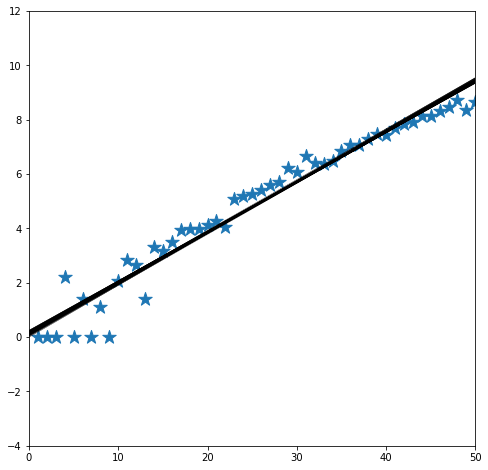

In [282]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-20, 20))
myplot_sample_lines(mu, sigma, points=points, n=100)

In [268]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
    return res

In [314]:
def plot_predictions(xs, mu, x, non_log_points):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlim((0, 60))
    ax.set_ylim((0, 15000))
    ax.plot(xs, np.exp(mu[1]*xs + mu[0]), color="red")
    ax.scatter(non_log_points[0], non_log_points[1], marker='*', s=200)
    ax.scatter(x_test, y_test_non_log, marker='o', s=100)

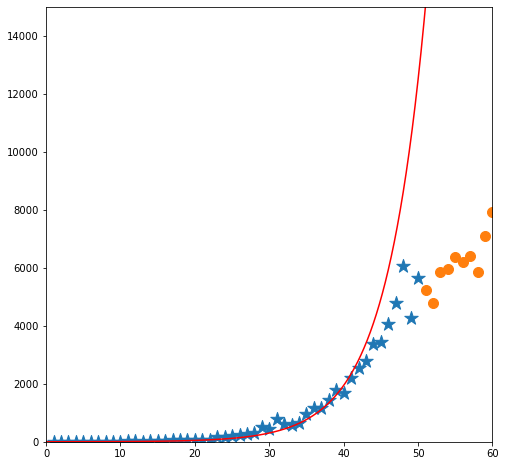

In [315]:
x = sample_statistics(mu, sigma, xs, n=2000)
plot_predictions(xs, mu, x, non_log_points)

## 3а. Линейная регрессия с сигмоидальным ростом числа заболевших

In [332]:
poly_coef = np.polyfit(x_train, y_train, 2)
poly_reg = np.poly1d(poly_coef)
a, b, c = poly_reg.c

poly_mu = -b / (2*a)
poly_sigma = np.sqrt(-1 / (2*a))
print(poly_mu, poly_sigma)

76.31540204360023 16.530435832089815


## 3b. Нахождение апостериорного распределения параметров модели

## 3с. Сэмплирование